# Second-Hand Car Price Estimation

The Rusty Bargain used car sales service is developing an application to attract new customers. With this app, you can quickly find out the market value of your car. You have access to the history: technical specifications, equipment versions, and prices. You need to create a model that determines the market value.
Rusty Bargain is interested in:
- The quality of the prediction.
- The speed of the prediction.
- The training time required.

# Initialization

In [124]:
# Load libraries

# Data manipulation
import math
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
import xgboost as xgb

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Load data

In [125]:
# Load the data into a DataFrame
df = pd.read_csv('../datasets/car_data.csv')

# Prepare data

In [126]:
# Select the columns that will be used
chosen_columns = [
    "Price",
    "VehicleType",
    "RegistrationYear",
    "Gearbox",
    "Power",
    "Model",
    "Mileage",
    "FuelType",
    "Brand",
    "NotRepaired"
]

# Create a new DataFrame with the selected columns
df = df[chosen_columns]

# Parse values of the column "NotRepaired" to boolean
df["NotRepaired"] = df["NotRepaired"].replace({"yes": True, "no": False})

In [127]:
# Print the general/summary information about the DataFrame
df.info()

# Print a random sample of 5 rows from the DataFrame
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Mileage           354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
103303,950,NaN,2017,manual,85,astra,150000,petrol,opel,NaN
329716,3300,small,2006,manual,0,clio,90000,petrol,renault,False
298873,3100,sedan,2008,NaN,0,passat,150000,gasoline,volkswagen,False
306042,4600,sedan,2004,manual,105,golf,150000,gasoline,volkswagen,False
253480,6990,sedan,2011,manual,90,i_reihe,100000,gasoline,hyundai,False


In [128]:
# Get rid of the records with missing values on "Model" column
df = df.dropna(subset=["Model"])

# Get rid of the records with missing values on "VehicleType" column
df = df.dropna(subset=["VehicleType"])

# Get rid of the records with missing values on "Gearbox" column
df = df.dropna(subset=["Gearbox"])

# Get rid of the records with missing values on "FuelType" column
df = df.dropna(subset=["FuelType"])

# Impute missing values on "NotRepaired" column with "no", considering that they are second-hand cars
df["NotRepaired"] = df["NotRepaired"].fillna(False).astype("uint8")

# Reset the index of the DataFrame
df = df.reset_index(drop=True)

In [129]:
# Print the general/summary information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284126 entries, 0 to 284125
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             284126 non-null  int64 
 1   VehicleType       284126 non-null  object
 2   RegistrationYear  284126 non-null  int64 
 3   Gearbox           284126 non-null  object
 4   Power             284126 non-null  int64 
 5   Model             284126 non-null  object
 6   Mileage           284126 non-null  int64 
 7   FuelType          284126 non-null  object
 8   Brand             284126 non-null  object
 9   NotRepaired       284126 non-null  uint8 
dtypes: int64(4), object(5), uint8(1)
memory usage: 19.8+ MB


## Intermediate Conclusion

The `Model` column is of great importance for data imputation because the model of a car can be a good indicator of its different characteristics. Therefore, it was decided to use this column as the basis for imputing some columns with missing values, and records that did not have this data were also removed.

The missing values in the `NotRepaired` column were filled with "no" since this value is the mode, and there is a high probability that a used car has had repairs.

**NOTE:** It should be mentioned that the `Power` column contains a considerable number of zero values.

In [130]:
# Explore values on the "VehicleType" column
df["VehicleType"].value_counts()

sedan          83020
small          70089
wagon          58946
bus            26372
convertible    18193
coupe          14337
suv            10686
other           2483
Name: VehicleType, dtype: int64

In [131]:
# Explore values on the "Gearbox" column
df["Gearbox"].value_counts()

manual    226192
auto       57934
Name: Gearbox, dtype: int64

In [132]:
# Explore values on the "FuelType" column
df["FuelType"].value_counts()

petrol      189857
gasoline     88809
lpg           4617
cng            492
hybrid         191
other          101
electric        59
Name: FuelType, dtype: int64

In [133]:
# Only keep the 10 most frequent values on the "Model" column and replace the rest with "other"
df.loc[~df["Model"].isin(df["Model"].value_counts().head(10).index), "Model"] = "other"

# Explore values on the "Model" column
df["Model"].value_counts()

other       181414
golf         23569
3er          17398
polo         10584
corsa        10048
astra         8920
a4            8773
passat        8757
c_klasse      7485
5er           7178
Name: Model, dtype: int64

In [134]:
# Only keep the 10 most frequent values on the "Brand" column and replace the rest with "other"
df.loc[~df["Brand"].isin(df["Brand"].value_counts().head(10).index), "Brand"] = "other"

# Explore values on the "Brand" column
df["Brand"].value_counts()

volkswagen       60598
other            53318
bmw              31248
opel             31020
mercedes_benz    27312
audi             24700
ford             20118
renault          13842
peugeot           8916
fiat              7475
seat              5579
Name: Brand, dtype: int64

In [135]:
# Select the categorical columns to be encoded with One-Hot Encoding
categorical_columns = [
    "VehicleType",
    "Gearbox",
    "FuelType",
    "Model",
    "Brand",
]

# Encode categorical columns with One-Hot Encoding
df_ohe = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Print the general/summary information about the DataFrame
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284126 entries, 0 to 284125
Data columns (total 38 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   Price                    284126 non-null  int64
 1   RegistrationYear         284126 non-null  int64
 2   Power                    284126 non-null  int64
 3   Mileage                  284126 non-null  int64
 4   NotRepaired              284126 non-null  uint8
 5   VehicleType_convertible  284126 non-null  uint8
 6   VehicleType_coupe        284126 non-null  uint8
 7   VehicleType_other        284126 non-null  uint8
 8   VehicleType_sedan        284126 non-null  uint8
 9   VehicleType_small        284126 non-null  uint8
 10  VehicleType_suv          284126 non-null  uint8
 11  VehicleType_wagon        284126 non-null  uint8
 12  Gearbox_manual           284126 non-null  uint8
 13  FuelType_electric        284126 non-null  uint8
 14  FuelType_gasoline        284126 non-

# EDA

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_16769/3252321828.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_ohe["Price"], bins=100)


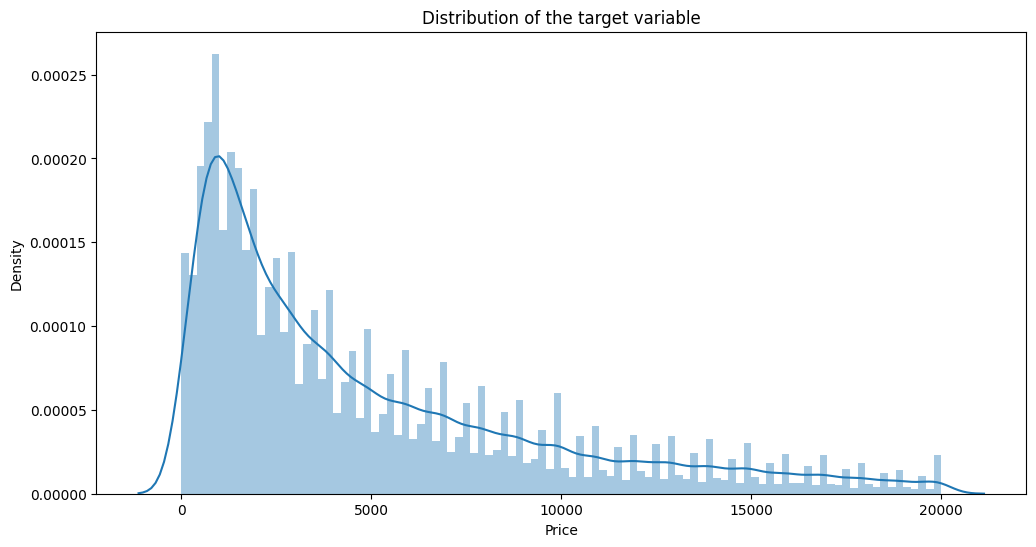

count    284126.000000
mean       4847.265516
std        4637.056831
min           0.000000
25%        1300.000000
50%        3199.000000
75%        6999.000000
max       20000.000000
Name: Price, dtype: float64

In [136]:
# Create a graph to visualize the distribution of the target variable
plt.figure(figsize=(12, 6))
sns.distplot(df_ohe["Price"], bins=100)
plt.title("Distribution of the target variable")
plt.xlabel("Price")
plt.ylabel("Density")
plt.show()

# Print the descriptive statistics of the target variable
df_ohe["Price"].describe()

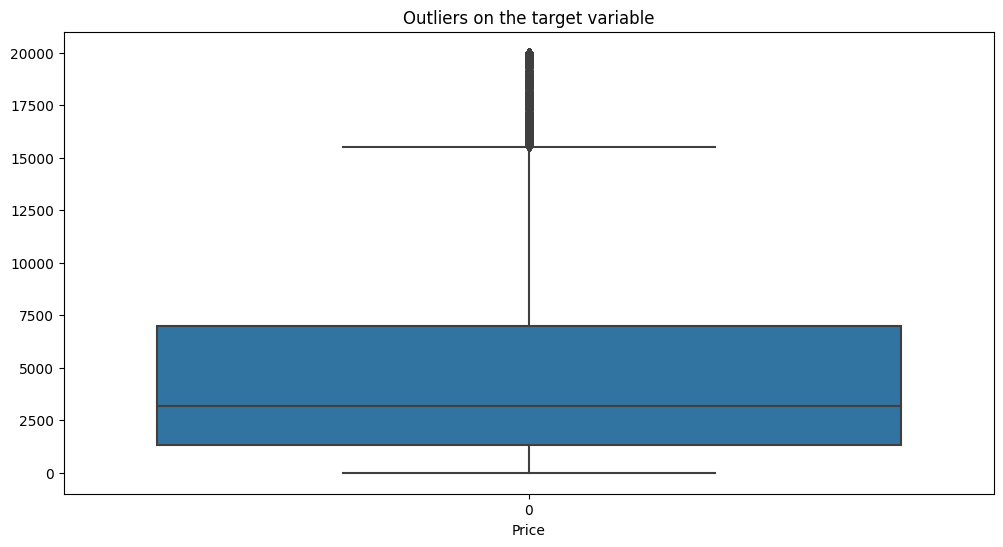

In [137]:
# Create a graph to visualize outliers on the target variable
plt.figure(figsize=(12, 6))
sns.boxplot(df_ohe["Price"])
plt.title("Outliers on the target variable")
plt.xlabel("Price")
plt.show()

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_16769/3517061120.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_ohe["Price"], bins=100)


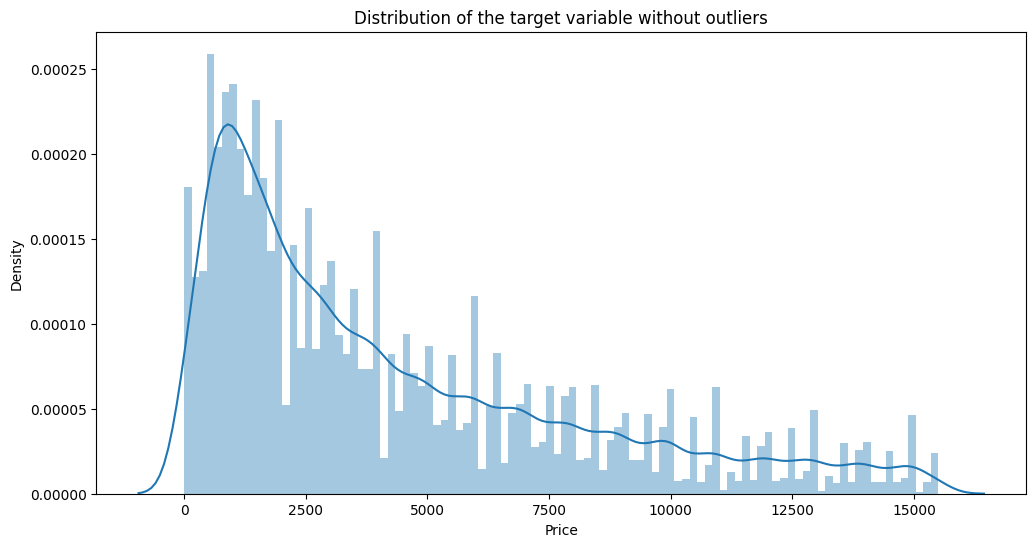

In [138]:
# Calculate the first and third quartiles
Q1 = df_ohe["Price"].quantile(0.25)
Q3 = df_ohe["Price"].quantile(0.75)

# Calculate the interquartile range
IQR = Q3 - Q1

# Calculate the upper and lower bounds
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Get rid of the outliers
df_ohe = df_ohe[df_ohe["Price"].between(lower_bound, upper_bound)].reset_index(drop=True)

# Create a graph to visualize the distribution of the target variable
plt.figure(figsize=(12, 6))
sns.distplot(df_ohe["Price"], bins=100)
plt.title("Distribution of the target variable without outliers")
plt.xlabel("Price")
plt.ylabel("Density")
plt.show()

# Model construction

In [139]:
# Set random seed for reproducibility
random_state = 12345

## Data Segmentation

In [140]:
# Split the data into training and test sets
train_ohe, test_ohe = train_test_split(df_ohe, test_size=0.25, random_state=12345)

# Split the training and test sets into features and targets
train_features_ohe = train_ohe.drop("Price", axis=1)
train_targets_ohe = train_ohe["Price"]
test_features_ohe = test_ohe.drop("Price", axis=1)
test_targets_ohe = test_ohe["Price"]

## Find the best hyperparameters

In [141]:
# Create a function to find the best hyperparameters
def find_best_params(model, param_grid, train_features, train_targets):
    # Perform a grid search of the hyperparameters
    grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')
    grid.fit(train_features, train_targets)
    
    # Print the best hyperparameters and the best score
    print('Model:', type(model).__name__)
    print('Best hyperparameters:', grid.best_params_)
    print('Best score:', np.abs(grid.best_score_))
    print()

In [142]:
# Define the models and their hyperparameters
models = [
    {
        'model': LinearRegression(),
        'param_grid': {}
    },
    {
        'model': RandomForestRegressor(random_state=random_state),
        'param_grid': {'n_estimators': np.arange(50, 201, 50), 'max_depth': np.arange(3, 15)}
    },
    {
        'model': CatBoostRegressor(random_state=random_state, verbose=False),
        'param_grid': {'iterations': np.arange(50, 201, 50), 'depth': np.arange(3, 15)}
    },
    {
        'model': xgb.XGBRegressor(random_state=random_state, verbosity=0),
        'param_grid': {'n_estimators': np.arange(50, 201, 50), 'max_depth': np.arange(3, 15)}
    },
]

# Find the best hyperparameters for each model
for model in models:
    find_best_params(model['model'], model['param_grid'], train_features_ohe, train_targets_ohe)

Model: LinearRegression
Best hyperparameters: {}
Best score: 1783.9776680984965

Model: RandomForestRegressor
Best hyperparameters: {'max_depth': 14, 'n_estimators': 150}
Best score: 1021.8866704341684

Model: CatBoostRegressor
Best hyperparameters: {'depth': 14, 'iterations': 200}
Best score: 949.9990472981866

Model: XGBRegressor
Best hyperparameters: {'max_depth': 13, 'n_estimators': 50}
Best score: 944.6290749285479



In [146]:
# Set the hyperparameters for each model
models = [
    LinearRegression(),
    RandomForestRegressor(n_estimators=150, max_depth=14, random_state=random_state),
    CatBoostRegressor(iterations=200, depth=14, random_state=random_state, verbose=False),
    xgb.XGBRegressor(n_estimators=50, max_depth=13, random_state=random_state, verbosity=0)
]

## Train and evaluate models

In [147]:
# Create a function to train and evaluate multiple models on the training and validation subsets and create a graph to visualize the results
def train_and_evaluate_models(models, train_features, train_target, test_features, test_target):
    # Create a DataFrame to store the results
    results = pd.DataFrame(columns=['Model', 'RMSE', 'R2', 'Training time', 'Prediction time'])
    
    # Loop through each model
    for model in models:
        # Train the model
        start = time.time()
        model.fit(train_features, train_target)
        end = time.time()
        train_time = end - start

        # Make predictions
        start = time.time()
        predictions = model.predict(test_features)
        end = time.time()
        test_time = end - start

        # Calculate the metrics
        rmse = math.sqrt(mean_squared_error(test_target, predictions))
        r2 = r2_score(test_target, predictions)
        
        # Append the results to the DataFrame
        results = results.append({'Model': model.__class__.__name__, 'RMSE': rmse, 'R2': r2, 'Training time': train_time, 'Prediction time': test_time}, ignore_index=True)
    
    # Draw a heatmap to visualize the results
    plt.figure(figsize=(14,7))
    sns.set(style="whitegrid")
    sns.heatmap(results.set_index('Model'), annot=True, cmap='RdBu_r')
    plt.title('Model Comparison')
    plt.ylabel('Model')
    plt.tight_layout()
    plt.show()

    return results

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_16769/2370451327.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model.__class__.__name__, 'RMSE': rmse, 'R2': r2, 'Training time': train_time, 'Prediction time': test_time}, ignore_index=True)
/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_16769/2370451327.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model.__class__.__name__, 'RMSE': rmse, 'R2': r2, 'Training time': train_time, 'Prediction time': test_time}, ignore_index=True)
/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_16769/2370451327.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.

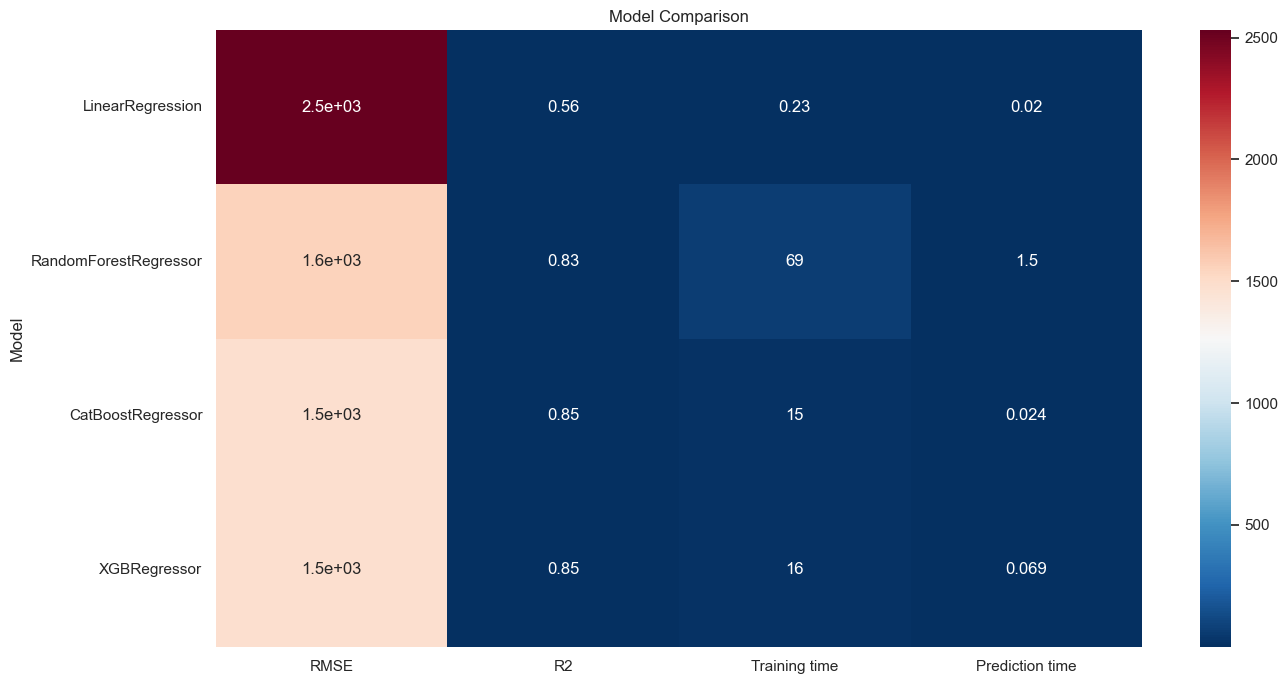

,Model,RMSE,R2,Training time,Prediction time
0,LinearRegression,2530.093950,0.559742,0.234263,0.020034
1,RandomForestRegressor,1552.796793,0.834170,68.623023,1.474471
2,CatBoostRegressor,1475.324176,0.850304,15.307073,0.024428
3,XGBRegressor,1475.989173,0.850169,15.852580,0.068761


In [148]:
# Train and evaluate the models
results = train_and_evaluate_models(models, train_features_ohe, train_targets_ohe, test_features_ohe, test_targets_ohe)

# Print the results
results

## Intermediate Conclusion

`CatBoost` appears to be the most efficient model, providing the lowest RMSE score, highest R2 value and the second lowest training and prediction times compared to the other models.

# General Conclusion

During this project for the second-hand car sales service at `Rusty Bargain`:

1. We have cleaned and imputed data, focusing on the variable `Model` to improve data quality.

2. We implemented and compared several regression models (Linear Regression, Random Forest, CatBoost, and XGBoost) to predict the market value of used vehicles. The gradient boosting models (CatBoost and XGBoost) showed superior performance.

3. We improved the accuracy of the models by adjusting hyperparameters, achieving a balance between accuracy and efficiency.

4. We chose the `CatBoost` model based on the results of the `RMSE` and `R2` metrics, as well as the training time and prediction time.

In summary, we have developed a model that can accurately predict the market value of used vehicles, providing a valuable tool for Rusty Bargain and highlighting the importance of careful data handling and a balanced consideration between model accuracy and efficiency.